In [1]:
#Libraries
import sys

import numpy as np
from scipy.optimize import curve_fit
import itertools
from Modules.read_data_from_cluster import read_MC
# from read_data_from_cluster import read_MC


Definitions of the colours trhoug all the computations

In [2]:
#Set fonts for all the plots. We use latex font. We can tune all parameters once and for all."""
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

#Colorblind friendly color cycle.

color = [ 'turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']

In [3]:
def derivative(f, dx):
    """
    Input;
    f, dx ---> function to derive and finite difference
    Outputs:
    x_m ---> derivative via syummetryc first order formula.
    """
    df = lambda x: (f(x+dx/2)-f(x-dx/2))/dx
    return df

class fit_pade:
    """
    Class to perform a pade fitting.
    Input;
    n,m ---> orders of the Padé
    """
    #
    def __init__(self, n,m):
        self.n = n
        self.m = m
#
    def evalua_pade(self,x,*para):
        """
        Input;
        x     --->    value at which to evaluate
        *para ---> parameters of the padé, they depends on n, m variable of the class
        Outputs:
        x     --->  value of the padé function at x
        """
        a = para[0:self.n]
        b = para[self.n:]
        y = sum( a[i]* x**i for i in range(len(a)))/ (1 + sum(b[i] * x**i for i in range(len(b))))
        return y
#
    def func_pade(self,*para):
        """
        Input;
        *para ---> parameters of the padé, they depends on n, m variable of the class.
        Outputs:
        func     --->  the padé approximation as a labmda function
        """
        a = para[0:self.n]
        b = para[self.n:]
        func = lambda x: sum( a[i]* x**i for i in range(len(a)))/ (1 + sum(b[i] * x**i for i in range(len(b))))
        return func

    def fitea_p(self,x,y, y_err, igu, verbose = False):
        """
        Input;
        x, y, yerr ---> data to fit.
        Outputs:
        igu     --->  parameters of the fitting
        """
        popt, pcov = curve_fit(self.evalua_pade, x, y, igu, sigma = y_err, maxfev = 5000000)
        perr = np.sqrt(np.abs(np.diag(pcov)))
        r = y - self.evalua_pade(x, *popt)
        res = r/y_err
        chisq = sum((res) ** 2)/(y_err.shape[0]-len(igu))
        if verbose: print("chisq/df",chisq)
        return popt, perr, chisq, res

    def pade_opt_rand(self,x, y, y_err, ntr=10, verbose = True):
        """
        Fitea via Pade for many random initial parameters, so that the variance is extracted from all those
        fits in a similar fashion as for bootstrap.
        Input;
        x, y, yerr ---> data to fit.
        Outputs:
        igu     --->  parameters of the fitting
        """
        # Return opt_parameter, errors, reduced_chis, res
        igu = [np.random.rand(self.n+self.m) for i in range(ntr)]
        res = [self.fitea_p(x,y, y_err, p0) for p0 in igu]
        xchi = np.array([res[i][2] for i in range(ntr)])
        ic = (np.abs(xchi)).argmin()
        mu = np.sum(xchi)/ntr
        var = np.sqrt(np.sum(xchi**2)/ntr-mu**2)
        if verbose:
            print("best estimation has order", self.n,self.m,"  and rchi", xchi[ic])
        return res[ic]

    def sev_func_pade(self,x,y,y_err, ntr = 100):
        """
        Fitea via Pade for all curves
        Input;
        x, y, yerr ---> data to fit.
        Outputs:
        igu     --->  parameters of the fitting
        """
        if type(x) == list:
            n = len(x)
            yv = [self.pade_opt_rand(x[i],y[i], y_err[i], ntr = ntr) for i in range(n)]
            para = [yv[i][0] for i in range(n)]
            rchi = [yv[i][2] for i in range(n)]
            func = [self.func_pade(*para[i]) for i in range(len(yv))]
        else:
            yv = self.pade_opt_rand(x,y, y_err, ntr = ntr)
            para = yv[0]
            rchi = yv[2]
            func = self.func_pade(*para)
        return func, para, rchi

    def der_pade(self,para):
        a = para[:self.n]
        b = para[self.n:]
        #print(para)
        Af = lambda x: sum( a[i]* x**i for i in range(len(a)))
        Bf = lambda x: (1 + sum(b[i] * x**i for i in range(len(b))))
        Ap = lambda x: sum( a[i]* i * x**(i-1) for i in range(1,len(a)))
        Bp = lambda x: (sum(b[i] *i* x**(i-1) for i in range(1,len(b))))
        y = lambda x: Ap(x)/Bf(x) - (Bp(x)*Af(x))/(Bf(x))**2
        return y
    def der2_pade(self,para):
        a = para[:self.n]
        b = para[self.n:]
        #print(para)
        Af = lambda x: sum( a[i]* x**i for i in range(len(a)))
        Bf = lambda x: (1 + sum(b[i] * x**i for i in range(len(b))))
        Ap = lambda x: sum( a[i]* i * x**(i-1) for i in range(1,len(a)))
        Bp = lambda x: (sum(b[i] *i* x**(i-1) for i in range(1,len(b))))
        App = lambda x: sum( a[i] *i*(i-1) * x**(i-2) for i in range(2,len(a)))
        Bpp = lambda x: (sum(b[i] *i*(i-1) * x**(i-2) for i in range(2,len(b))))
        y = lambda x: App(x)/Bf(x) - 2*Ap(x)*Bp(x)/(Bf(x))**2 + 2*Af(x)*(Bp(x))**2/(Bf(x))**3 - \
                    Af(x)*Bpp(x)/(Bf(x))**2
        return y

def pade_best(x,y,y_err, ntr=100, ic = [4,5], jc = [2,3]):
    fpade = []
    st_chi = []
    st_ce = []
    od = []
    inx = itertools.product(ic, jc)
    for order in inx:
        A = fit_pade(*order)
        f_sev, pade_c, rchi = A.sev_func_pade(x[:],y[:], y_err[:], ntr = ntr)
        if type(x) == list:
            df = [A.der_pade(pade_c[i]) for i in range(len(pade_c))]
            d2f = [A.der2_pade(pade_c[i]) for i in range(len(pade_c))]
        else:
            df = A.der_pade(pade_c)
            d2f = A.der2_pade(pade_c)
        od.append(order)
        st_chi.append(rchi)        
        fpade.append(f_sev)
    st_chi = np.array(st_chi)
    if type(x) == list:
        inopt = [(np.abs(np.array(st_chi[:,i])-1)).argmin() for i in range(len(x))]
        fpade_out = [fpade[inopt[i]][i] for i in range(len(x))] 
        print([st_chi[inopt[i],i] for i in range(len(x))])
    else:
        inopt = (np.abs(np.array(st_chi)-1)).argmin() 
        fpade_out = fpade[inopt] 
        print("best rchi",st_chi[inopt])
    return fpade_out, df, d2f, st_chi[inopt]


# Fitting function:

Parameters: 

rho  --> order of expansion in relevant field

ns   --> order of expansion in the function itself

nb   --> order of expansion in irrelevant field

We look for a scaling form in variable $f$ in Taylor expansion:

$$f\left(L^{1/\nu}\rho(W), L^{-|y|}u_i(W)\right)$$

Subroutine fitea_p is the main one to fit data. Inputs are:

xopt   --> [temperature, sizes]

yopt   --> Data to scale

y_error   --> errors in data

Outputs:

popt  --> Best fitting parameters 

perr  --> errors in best fitting parameters

chisq --> chisq divided between degrees of freedom. Good fitting should give around 1

res   --> residuos.



In [4]:
import scipy.stats as stats
# from scipy.special import gamma, factorial
class fitea_order_man:
    #
    # 
    def __init__(self, nrho, ns, nb):     
        self.nrho = nrho
        self.ns = ns
        self.nb = nb
        self.nt = ns+nrho+nb
        if ns < 2:
            print("WARNING: the minimum ns should be 2 to include scaling variable!")
    """
    Inputs:
    x       ---> points where to evaluate function, like temperature and size
    para    ---> parameters of the function to minimize. We will always assume that the last two parameters are critical ex
                 ponent and disorder
    Outputs:
    f       ---> function evaluated at the points x. 
    """
    def func2(self,x,*para):
        a = para[0:self.ns]
        d = para[self.ns:self.ns+self.nrho]
        b = para[self.ns+self.nrho: self.ns+self.nrho+ self.nb]
        nu = para[self.ns+self.nrho+ self.nb]
        wc = para[self.ns+self.nrho+ self.nb+1]
#         print(a,d,nu,wc)
        rho = (x[0]-wc) + sum( d[i]* (x[0]-wc)**(i+2) for i in range(self.nrho))
        xs =  rho * x[1]**(1/nu) 
        beta = sum( b[i] * (x[0]-wc)**(i) for i in range(self.nb))
        #First, without irrelevant corrections
        if self.nb == 0: 
            f = sum(a[i]* xs**i for i in range(self.ns))
        # now with irrelevant corrections in simple form:
        elif self.nb > 0:
            yi = para[-1]
            # f =  f0(xs) + (1+ui * L^{-y})
            f = x[1]**-1 * sum(a[i]* xs**i for i in range(self.ns))   *(1+beta * x[1]**(-yi))
        return f
    """
    Inputs:
    x_opt  ---> x parameter of fitting function. That typically includes parameter that drive the 
                    transition and size of the system
    y_opt  ---> value of order parameter
    y_err  ---> errors in order parameter 
    Ouputs:
    popt, perr  ----> optimized values of parameters togehter with covarianze matrix
    chisq       ----> value of reduced chisq
    res         ----> residues
    """     
    def fitea_p(self,x_opt,y_opt, y_err, nu_i = 1, w_i =1, y_i = 1, verbose = True):
        igu = [np.random.rand()/1 for i in range((self.nrho+self.ns+self.nb))]
#         print(igu)
        if self.nb == 0:
            igu.extend([nu_i,w_i])
        else:
            igu.extend([nu_i,w_i,y_i])
        popt, pcov = curve_fit(self.func2, x_opt, y_opt, igu, sigma = y_err, absolute_sigma= "False",maxfev=1000000)
        perr = np.sqrt(np.diag(pcov))
        r = y_opt - self.func2(x_opt, *popt)
        res = r/y_err
        df = y_err.shape[0]-len(igu)
        chisq = sum((res) ** 2)
        print("numero de puntos",y_err.shape[0])
        print("grados de libertad, ", df)
        p =  stats.chi2.cdf(chisq, df)
        print("value of 1-cdf", 1-p , "actual value", chisq*df)
        print("chisq/df",chisq/df)
        if verbose:
            for i in range(len(igu)):
                print(popt[i], "+-", perr[i])  
        return popt, perr, chisq, res

    
    def give_c(self,x,*para):
        a = para[0:self.ns]
        d = para[self.ns:self.ns+self.nrho]
        b = para[self.ns+self.nrho: self.ns+self.nrho+ self.nb]
        nu = para[self.ns+self.nrho+ self.nb]
        wc = para[self.ns+self.nrho+ self.nb+1]
#         print(a,d,nu,wc)
        rho = (x[0]-wc) + sum( d[i]* (x[0]-wc)**(i+2) for i in range(self.nrho))
        xs =  rho * x[1]**(1/nu) 
        beta = sum( b[i] * (x[0]-wc)**(i) for i in range(self.nb))
        if self.nb == 0: 
            f = 0
        elif self.nb > 0:
#             y = para[-1]
            f = x[1]**-1 * sum(a[i]* xs**i for i in range(self.ns))   *(1+beta * x[1]**(-yi))
        return f, nu, wc
    
    def sc_function(self,*para):
        if self.nrho > 0:
            print("WARNING: the scaling function also dependes on W-W_c!")
        a = para[0:self.ns]
    #         print(a,d,nu,wc)
        f = lambda x: sum(a[i]* x**i for i in range(self.ns))
        return f    
    def give_scalingv(self, x, *para):
        a = para[0:self.ns]
        d = para[self.ns:self.ns+self.nrho]
        b = para[self.ns+self.nrho: self.ns+self.nrho+ self.nb]
        nu = para[self.ns+self.nrho+ self.nb]
        wc = para[self.ns+self.nrho+ self.nb+1]
#         print(a,d,nu,wc)
        rho = (x-wc) + sum( d[i]* (x-wc)**(i+2) for i in range(self.nrho))        
        return rho

def separa(x, s, y, y_e):
    xp = []
    sp = []
    yp = []
    yp_e = [] 
    nc = 0
    for i  in range(len(x)-1):
        if x[i] > x[i+1]:
            xp.append(x[nc:i+1])
            yp.append(y[nc:i+1])
            yp_e.append(y_e[nc:i+1])
            sp.append(s[nc:i+1])
            nc = i+1
    xp.append(x[nc:])
    yp.append(y[nc:])
    sp.append(s[nc:])
    yp_e.append(y_e[nc:])
    return xp, sp, yp, yp_e

def data_fss(x1, x2, y, yerr, x1min=-10000, x1max=10000):
    """
    This function transform a set of data y in array togeter with parameter x1 (like temperature) and x2 size for 
    each enter of array y to a new x y f, corresponding each entry to a value of temperature, size and order parameter.
    For instances x1 = [[1,2,3], [1,2,3] ] the x2 = [100,200] and y =[[0,0.1,0.2],[0.3,0.5,10]] would end up in
    x = [1,2,3,1,2,3] y = [100,100,100,200,200,200] f = [0,0.1,0.2,0.3,0.5,10]. That is,
    the original data where (x1[i],y[i]) for the size x2[i].  The output contains
    three array x with temperature, y with sizes and f with order parameter. 
    Inputs:
    x1    ---> numpy array with disorder
    x2    ---> numpy array with sizes
    y     ---> numpy array with data to fit
    yerr  ---> numpy with data errors
    x1min,xmax --->  interval where to restrict data
    Outputs:
    x     ---> parameter driving the transition like T
    y     ---> analogous of size L.
    f     ---> value of the order parameters in each of the parameters contained in x
    ferr  ---> errors.
    """
    indx = [np.where(np.logical_and(x1[i]>=x1min, x1[i]<=x1max)) for i in range(len(x1))]
    x1_n = [x1[i][indx[i]] for i in range(len(x1))]
    y_n = [y[i][indx[i]] for i in range(len(y))]
    yerr_n = [yerr[i][indx[i]] for i in range(len(y))]
    # Now, we construct three 1d arrays p1, p2 and q. The array q contains the quantity over which 
    # finite size analysis is performer. The p1 and p2 contains the values of parameter and size for
    # each of the entries of q
    x = np.concatenate(x1_n).ravel()
    y = np.concatenate([x2[i]*np.ones(len(x1_n[i])) for i in range(len(x1_n))] ).ravel()
    f = np.concatenate(y_n).ravel()
    ferr = np.concatenate(yerr_n).ravel()    
    return x, y, f, ferr

# Goals of the project


The main goal is to characterize the minimum hardware requirements in a quantum annealer so to display a spin-glass behaviour at the end of the passage. There are several ways to induce a classical spin glass at low temperature:

- Bravais lattices in 3D or more. The critical lower dimension of the spin-glass transition is at $D_{\rm l}=5/2$ (maiorano2018 PNAS), the upper critical dimension is $D_{\rm u}=6.$ It would be difficult to construct a quantum annealer with the 3D connectivity.  There are several works that obtain the absence of spin-glass in 2D, actually only at $T=0$ is there a spin-glass dynamic (Fernandez2016 PRB). 

- Fractal structures. One can try to save resources by reducing the dimension to a number between 2.5 and 3. There are several studies of spin-glass in Ising models with fractal structures. This one (Carmona1998 PRB) studies those transition for the ferro to paramagnet system in Serpinsky carpets, they showed that the relevant fractal dimension is the Hausdorf one, which obeys hyperscaling. A similar work for the case of spin-glasses in fractals on hierarchical lattices reports a lower critical dimension of 2.520. Remark that authors explicitly  says that this results hold only for type of hierarchichal models, meaning that they do not want to contradict the $5/2$ of Parisi et al. 

- Small world models. The last type of lattices are those refferred as small-world graphs. They are constructed from graphs with random bonds which are used as short-cuts. The average length between any two bonds would scale in a finite dimenssion as $\hat{l}\sim N^{1/d}.$ In an small-world network is $\hat{l}\sim \log(N) $, see (dorogovtsev2008) for review on small-world networks. 

We will focuss in the last type of networks, small-world ones, in order to produce graphs that are difficult to handdle by quantum Monte-Carlo. There are several results to bear in mind:

i) It seems that small-world networks are all described by mean-field exponents $\nu=1/2.$ However, it is not clear to me which scaling law one should follow. In finite dimensions one would use the system size $L$ to write: 

$$g=f(L^{\frac{1}{\nu}}(T-T_c))=f(N^{\frac{1}{d\nu}}(T-T_c)).$$

However, for small-world networks or random-regular graphs one should do:

$$g=f(L^{\frac{1}{\nu}}(T-T_c))= f([\log(L)]^{\frac{1}{\nu}}(T-T_c)).$$ 

Be carefull as in the work of Matteo Palasini and Katgraber (Liers2003) and (Katzgraber2018), they use scalings as $g=f(N^{\frac{1}{d_u\nu}}(T-T_c))=f(N^{\frac{1}{3}}(T-T_c))$ which may be wrong.









# Random regular Graph, k=5:


In [9]:
distribution = 'gaussian_EA'
adjacencies = ['random_regular_3', 'random_regular_5', 'random_regular_7', 'random_regular_9', '1D+', '1D+', '1D+', '1D+',
               '2D_small_world']
sizes = [100, 200, 400, 800, 1600, 3200]
add_vs_adj = [0, 0, 0, 0, 3.0, 5.0, 7.0, 9.0, 0]
T0_vs_adj = [0.2, 0.5, 0.5, 1.0, 0.5, 1.0, 1.3, 1.5, 0.5]
Tf_vs_adj = [1.5, 3.0, 3.0, 4.0, 2.5, 2.5, 3.0, 3.5, 2.5]
MCS_avg_0 = 10000
max_MCSs_vs_adj = [ MCS_avg_0 * 2 ** np.array([1, 2, 4, 6, 7, 7]),
                    MCS_avg_0 * 2 ** np.array([5, 5, 5, 5, 5, 5]) + 4,
                    MCS_avg_0 * 2 ** np.array([1, 2, 4, 4, 5, 6]) + 1,
                    MCS_avg_0 * 2 ** np.array([1, 2, 4, 5, 5, 6]),
                    MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 5, 6]),
                    MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 5, 6]),
                    MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 5, 6]),
                    MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 5, 6]),
                    MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 5, 6]) ]

In [10]:
adj_index = -1
adjacency = adjacencies[adj_index]
T0 = T0_vs_adj[adj_index]
Tf = Tf_vs_adj[adj_index]
add = add_vs_adj[adj_index]
max_MCSs = max_MCSs_vs_adj[adj_index]

In [11]:
T_vs_size, B_vs_size, error_vs_size, U_vs_size, ql_vs_size, N_configs_vs_size, MCS_avg_vs_size = \
read_MC(adjacency, distribution, sizes, add, T0, Tf, MCS_avg_0, max_MCSs)


In [12]:
Lfit = sizes
Tfit = [T[0] for T in T_vs_size]
Ofit = [B[-1] for B in B_vs_size]
Ofit_er = [err[-1] for err in error_vs_size]

# Plot Binder cumulant

/home/gabriel/anaconda3/envs/Architecture_v1/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


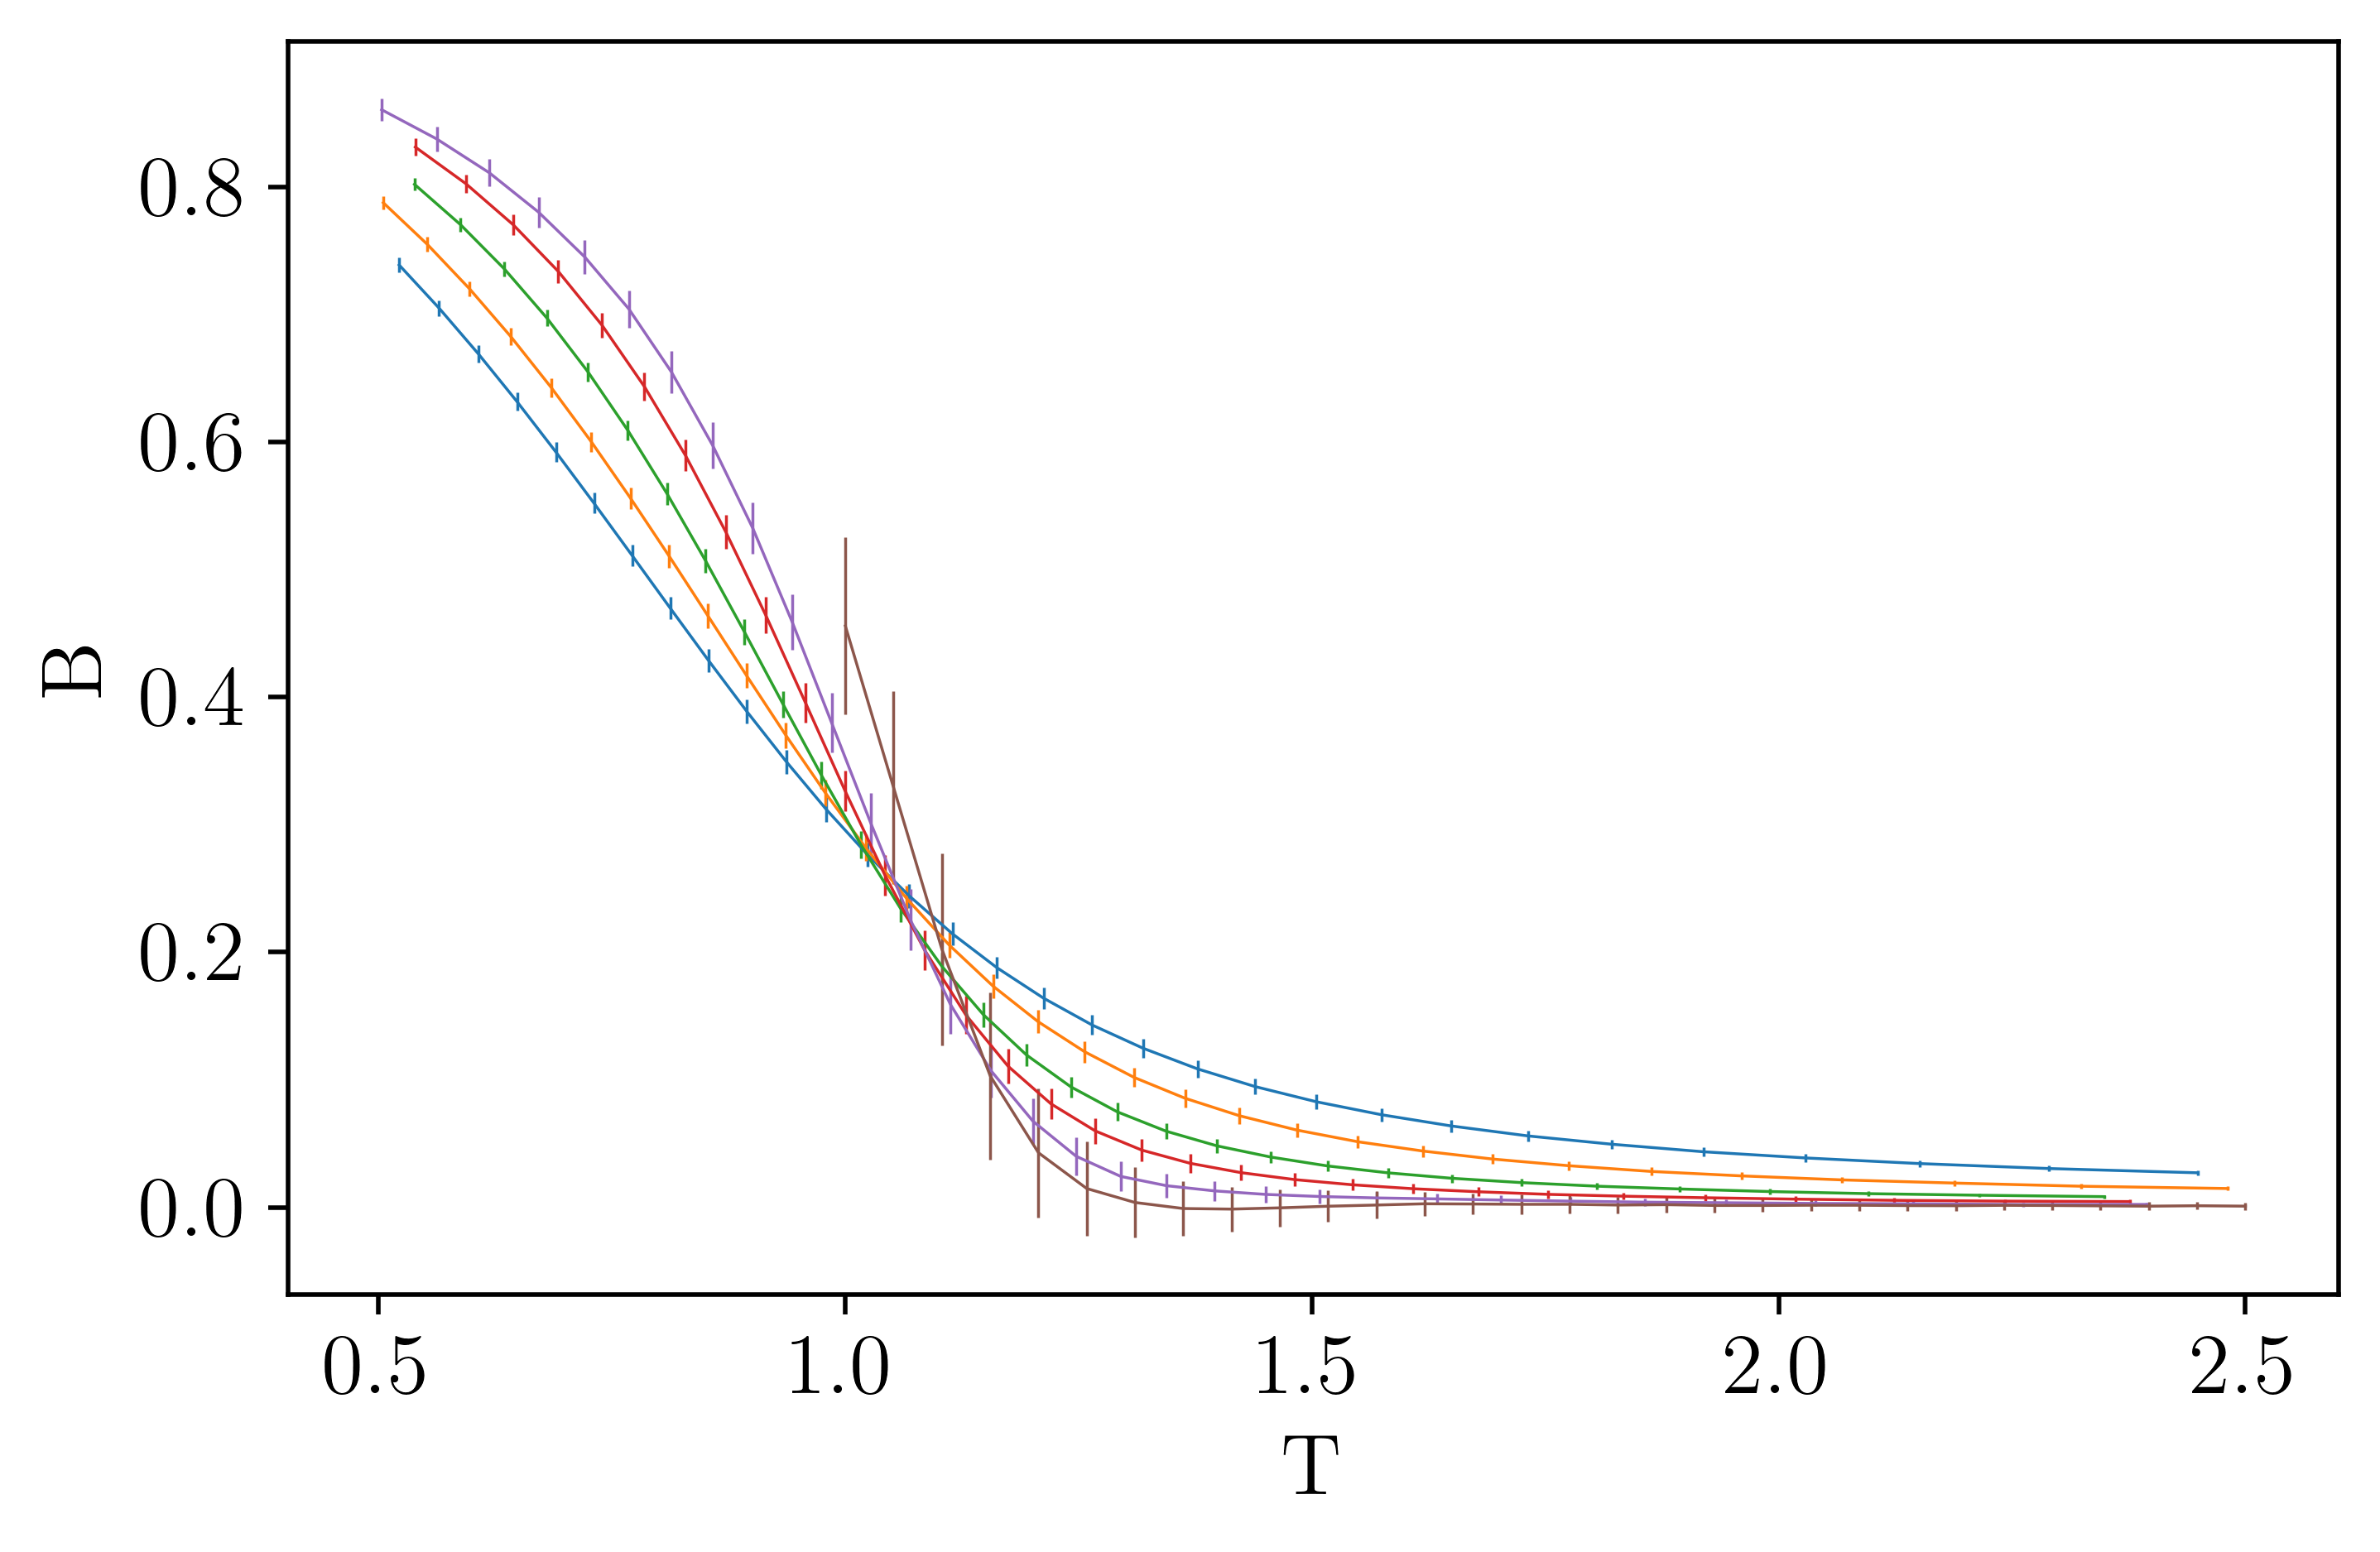

In [13]:
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=500)
for i in range(len(Tfit)):
    ax1.errorbar(Tfit[i], Ofit[i], yerr = Ofit_er[i], fmt="-", linewidth = 0.5)
ax1.set_xlabel('T')
ax1.set_ylabel('B')
fig.tight_layout()
fig.show()

We need to analyze:

i) The shift in the crossing point, it is due to an irrelevant corrections decaying with an exponent $y$ which should be determined.

ii) It seems that for the last three curves, the crossing point does not shift significantly. If this is the case, we need to find critical exponent. 

To do so, we first build the Padé approximants. After, we will obtain the point of larger slope for each system size.


In [14]:
nf = len(sizes)
fT, fT_d, d2T,l_rchi = pade_best(Tfit[0:nf], Ofit[0:nf], np.array(Ofit_er[0:nf]), ntr=4, ic = [5], jc = [6,7])


/home/gabriel/anaconda3/envs/Architecture_v1/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


best estimation has order 5 6   and rchi 0.00013515149039978176
best estimation has order 5 6   and rchi 0.0005011287591995849
best estimation has order 5 6   and rchi 0.0003631173593362404
best estimation has order 5 6   and rchi 0.0005252603918429206
best estimation has order 5 6   and rchi 0.003510246271580354
best estimation has order 5 6   and rchi 0.0017678553159362332
best estimation has order 5 7   and rchi 0.00014205460361108428
best estimation has order 5 7   and rchi 0.0005261490102548636
best estimation has order 5 7   and rchi 0.000365814459645032
best estimation has order 5 7   and rchi 0.0005516411212184943
best estimation has order 5 7   and rchi 0.0022696831628483795
best estimation has order 5 7   and rchi 0.0017765098095965754
[0.00014205460361108428, 0.0005261490102548636, 0.000365814459645032, 0.0005516411212184943, 0.003510246271580354, 0.0017765098095965754]


In [24]:
nf

6

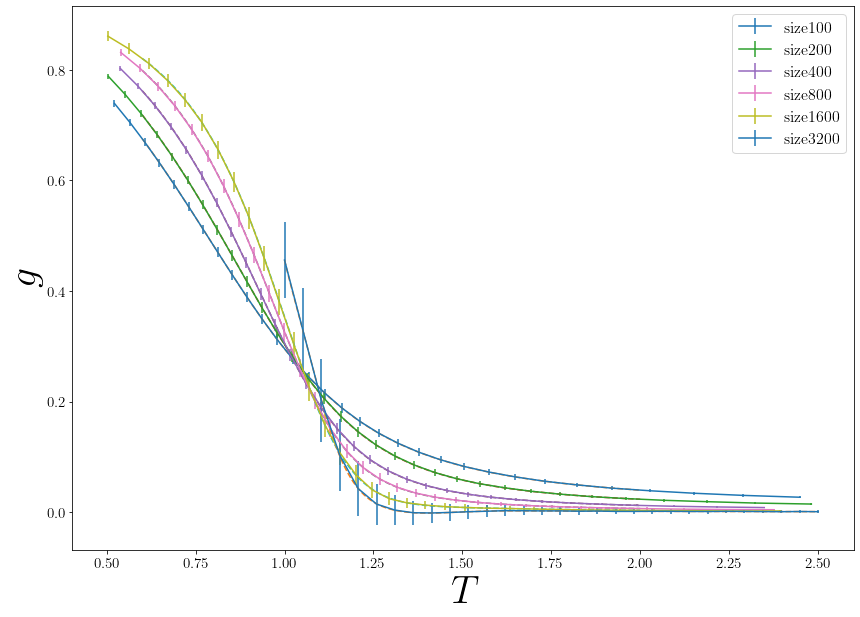

In [26]:
fig, ax1 = plt.subplots(figsize=(14,10))
x = np.linspace(1.2*T0,0.8*Tf,1000)
for i in range(nf):
    if i == nf-1:
        x = np.linspace(1.0,2.5,1000)
    
    ax1.errorbar(Tfit[i], Ofit[i] ,  yerr = Ofit_er[i] ,fmt='-', label =" size"+str(Lfit[i]))
    ax1.plot(x,fT[i](x),"--")
ax1.set_xlabel('$T$', fontsize=40)
ax1.set_ylabel("$g$", fontsize=40)
ax1.legend(fontsize=16)
handles, labels = ax1.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
# plt.savefig("T_rrgK5.pdf", bbox_inches='tight')

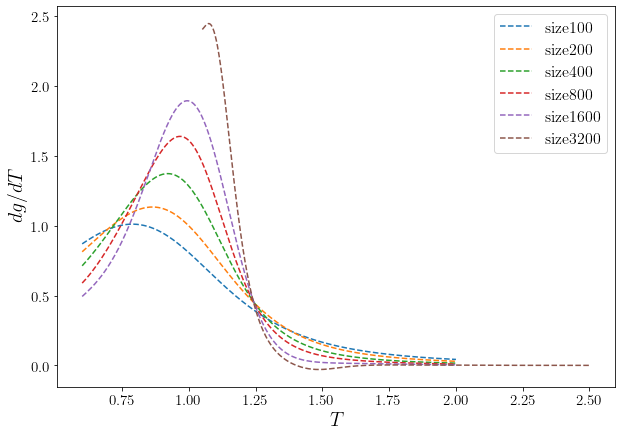

In [30]:
fig, ax1 = plt.subplots(figsize=(10,7))
x = np.linspace(1.2*T0,0.8*Tf,1000)

for i in range(0,nf):
#     ax1.errorbar(Tfit[i], Ofit[i] ,  yerr = Ofit_er[i] ,fmt='-', label =" size"+str(i))
    if i == nf-1:
        x = np.linspace(1.05,2.5,1000)
    ax1.plot(x,-fT_d[i](x),"--", label =" size"+str(Lfit[i]))
ax1.set_xlabel('$T$', fontsize=20)
ax1.set_ylabel("$dg/dT$", fontsize=20)
ax1.legend(fontsize=16)
# handles, labels = ax1.get_legend_handles_labels()
# remove the errorbars
# handles = [h[0] for h in handles]
# use them in the legend
# plt.savefig("D1_rrg.pdf", bbox_inches='tight')

# Crossover in continous phase transitions:


In standard second order phase transitions, where scaling arguments apply, a quantity $f$ showing a discontinuity would behave as:

$$ f(T,L)= \xi^{\zeta} g(L/\xi)$$

being $\xi$ the correlation length that diverges in the thermodynamical limit. For a finite system, the pseudo-critical disorder at finite length occurs when $L \approx \xi,$ that is:

$$T_L -T_c \sim 1/L^{1/\nu}$$

At these transition points, the function has reached the maximum $f(T_L, L)\sim L^{\zeta}$ Notice that in the book of Cardy, they use the supceptibility exponent $\gamma$ which is defined via $\chi\approx (T-T_c)^{\gamma}.$ In that book, the analytical corrections to scaling are summarized with the plot:

In [31]:
# Data to extrapolate the maxima
# x = np.linspace(0,2,1000)
gdmax = np.array([ -np.amin(fT_d[i](x)) for i in range(nf)])
sizes = np.array([Lfit[i] for i in range(nf)])
# To extrapolate the position of the maxima:
inx = [ np.argmin(fT_d[i](x)) for i in range(nf)] 
T_max = np.array([x[inx[i]] for i in range(nf)])

In [32]:
z = np.polyfit(1/sizes**(1/3), T_max[0:], 1)
print(z)
p = np.poly1d(z)
xx = np.linspace(0,0.25,100)

[-0.09482722  1.06624933]


Text(0, 0.5, '$T_c$')

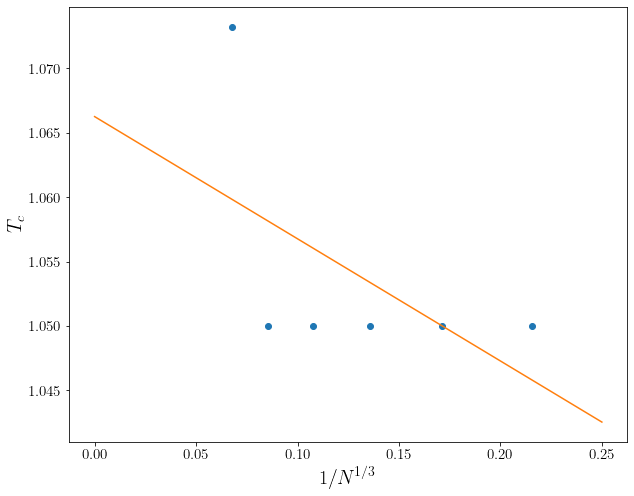

In [33]:
fig, ax1 = plt.subplots( figsize=(10,8))
ax1.plot(1/sizes**(1/3), T_max, "o")
ax1.plot(xx, p(xx), "-")
ax1.set_xlabel('$1/N^{1/3}$', fontsize=20)
ax1.set_ylabel("$T_c$", fontsize=20)
# ax1.set_ylim([1.75, 2.1])

(0.0, 1.5)

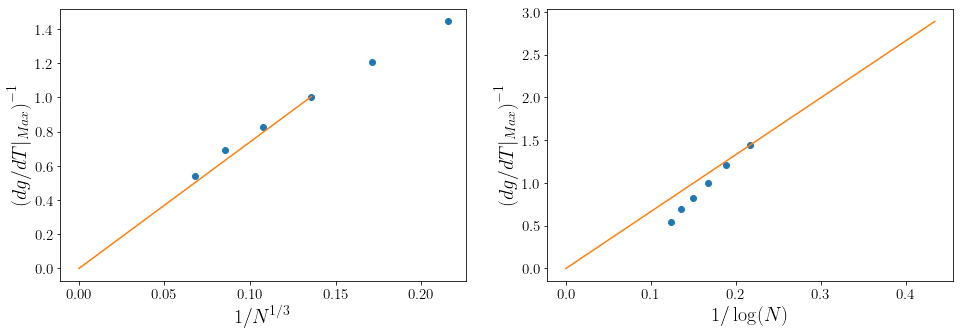

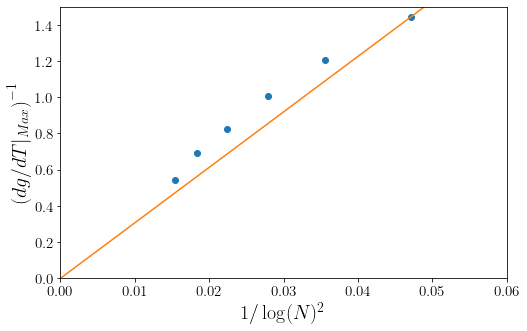

In [34]:
fig, ax1 = plt.subplots(1,2, figsize=(16,5))
# x = np.linspace(0,)
ax1[0].plot(1/sizes**(1/3), 1/gdmax, "o")
ax1[0].set_xlabel('$1/N^{1/3}$', fontsize=20)
ax1[0].set_ylabel("$\\left(dg/dT|_{Max}\\right)^{-1}$", fontsize=20)
ax1[0].plot([0,1/sizes[2]**(1/3)], [0,1/gdmax[2]], "-")
# ax1[0].set_xlim(0,0.25)
# ax1[0].set_ylim(0,1.5)

ax1[1].plot(1/np.log(sizes), 1/gdmax, "o")
ax1[1].set_xlabel('$1/\log(N)$', fontsize=20)
ax1[1].set_ylabel("$\\left(dg/dT|_{Max}\\right)^{-1}$", fontsize=20)
ax1[1].plot([0,2/np.log(sizes)[0]], [0,2/gdmax[0]], "-")
# ax1[1].set_xlim(0,0.25)
# ax1[1].set_ylim(0,1.5)

fig, ax2 = plt.subplots(figsize=(8,5))
ax2.plot(1/(np.log(sizes))**2, 1/gdmax, "o")
ax2.set_xlabel('$1/\log(N)^{2}$', fontsize=20)
ax2.set_ylabel("$\\left(dg/dT|_{Max}\\right)^{-1}$", fontsize=20)
ax2.plot([0,2/(np.log(sizes)[0])**2], [0,2/gdmax[0]], "-")
ax2.set_xlim(0,0.06)
ax2.set_ylim(0,1.5)